# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import time
import xgboost
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# Notebook Parameters

In [ ]:
# data
route_str = 'B46'
station_str = 'JFK'

# Read Data

In [ ]:
route_weather_df_4_ml_0 = pd.read_csv(f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Combined/bus_{route_str}_0_weather_{station_str}.csv')
route_weather_df_4_ml_1 = pd.read_csv(f'/content/drive/My Drive/Bus Watcher Spec Project/Projects/Alex Amy + Sanket Shah/Data/Combined/bus_{route_str}_1_weather_{station_str}.csv')

# compute 9-digit trip_id
route_weather_df_4_ml_0['trip_id_comp_9_dig_id'] = route_weather_df_4_ml_0['trip_id_comp_6_dig_id'] + route_weather_df_4_ml_0['trip_id_comp_3_dig_id']
route_weather_df_4_ml_1['trip_id_comp_9_dig_id'] = route_weather_df_4_ml_1['trip_id_comp_6_dig_id'] + route_weather_df_4_ml_1['trip_id_comp_3_dig_id']

# cast numerical trip_id components as ints
route_weather_df_4_ml_0['trip_id_comp_6_dig_id'] = route_weather_df_4_ml_0['trip_id_comp_6_dig_id'].astype(int)
route_weather_df_4_ml_0['trip_id_comp_3_dig_id'] = route_weather_df_4_ml_0['trip_id_comp_3_dig_id'].astype(int)
route_weather_df_4_ml_0['trip_id_comp_9_dig_id'] = route_weather_df_4_ml_0['trip_id_comp_9_dig_id'].astype(int)

route_weather_df_4_ml_1['trip_id_comp_6_dig_id'] = route_weather_df_4_ml_1['trip_id_comp_6_dig_id'].astype(int)
route_weather_df_4_ml_1['trip_id_comp_3_dig_id'] = route_weather_df_4_ml_1['trip_id_comp_3_dig_id'].astype(int)
route_weather_df_4_ml_1['trip_id_comp_9_dig_id'] = route_weather_df_4_ml_1['trip_id_comp_9_dig_id'].astype(int)

# Baseline Feature Importance

In [ ]:
def custom_train_test_split(data, split_heuristic='arbitrary', test_size=0.1, split_date=(9, 27, 2021), split_time=(0, 0), n=1, random_state=0):
  data = data.copy()

  # train-test split
  if split_heuristic == 'arbitrary':
    train, test = train_test_split(data, test_size=test_size, random_state=random_state)

  elif split_heuristic == 'date':
    month, day, year = split_date
    split_date = datetime.date(year=year, month=month, day=day)
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    date_test_end = split_date + datetime.timedelta(days=n)
    train = data[data['date'].dt.date < split_date]
    train = train.drop(columns='date')
    test = data[(data['date'].dt.date >= split_date) & (data['date'].dt.date <= date_test_end)]
    test = test.drop(columns='date')

  elif split_heuristic == 'time':
    month, day, year = split_date
    hour, minute = split_time
    split_time = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute)
    data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute']])
    time_test_end = split_time + datetime.timedelta(minutes=n)
    train = data[data['datetime'] < split_time]
    train = train.drop(columns='datetime')
    test = data[(data['datetime'] >= split_time) & (data['datetime'] <= time_test_end)]
    test = test.drop(columns='datetime')

  # define features / targets
  train_x = train.drop(columns=['passenger_count', 'year', 'day'])
  train_y = train['passenger_count']

  test_x = test.drop(columns=['passenger_count', 'year', 'day']) 
  test_y = test['passenger_count']

  return train_x, train_y, test_x, test_y

def train_eval_rf(train_x, train_y, test_x, test_y):
  # train model
  model = RandomForestRegressor(random_state=0)
  model.fit(train_x, train_y)

  # evaluate on train set
  print('Train')
  train_pred = model.predict(train_x)
  mae = mean_absolute_error(train_y, train_pred)
  me = max_error(train_y, train_pred)
  r2 = r2_score(train_y, train_pred)

  print(f'MAE: {mae:.1f}')
  print(f'ME : {me:.1f}')
  print(f'R^2: {r2:.2f}')
  print('\n')

  # evaluate on test set 
  print('Test')
  test_pred =  model.predict(test_x)
  mae = mean_absolute_error(test_y, test_pred)
  me = max_error(test_y, test_pred)
  r2 = r2_score(test_y, test_pred)

  print(f'MAE: {mae:.1f}')
  print(f'ME : {me:.1f}')
  print(f'R^2: {r2:.2f}')
  print('\n')

  return model

def plot_importance(model, train_x):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

  forest_importances = pd.Series(importances, index=train_x.columns)

  fig, ax = plt.subplots(figsize=(20, 10))
  forest_importances.plot.bar(yerr=std, ax=ax)
  ax.set_title("Feature Importances Using MDI")
  ax.set_ylabel("Mean Decrease in Impurity")
  fig.tight_layout()

def plot_cumulative_importance(model, train_x, train_y, test_x, test_y):
  importances = model.feature_importances_

  forest_importances = pd.Series(importances, index=train_x.columns)

  subset_features = []
  subset_training_times = []
  subset_test_maes = []
  subset_test_mes = []
  subset_test_r2s = []

  for feature in forest_importances.sort_values(ascending=False).index:
    subset_features.append(feature)
    subset_train_x = train_x[subset_features]
    subset_test_x = test_x[subset_features]

    model = RandomForestRegressor(random_state=0)
    
    beg = time.time()
    model.fit(subset_train_x, train_y)
    end = time.time()
    subset_train_time = end - beg
    subset_training_times.append(subset_train_time)

    subset_test_pred = model.predict(subset_test_x)

    subset_test_mae = mean_absolute_error(test_y, subset_test_pred)
    subset_test_me = max_error(test_y, subset_test_pred)
    subset_test_r2 = r2_score(test_y, subset_test_pred)

    subset_test_maes.append(subset_test_mae)
    subset_test_mes.append(subset_test_me)
    subset_test_r2s.append(subset_test_r2)

  # plot maes
  fig, ax1 = plt.subplots(figsize=(20, 10))
  ax1.plot(subset_test_maes, label='Test MAE (left)', color='darkorange')
  ax1.set_xticks(range(len(forest_importances.sort_values(ascending=False).index)))
  ax1.set_xticklabels(forest_importances.sort_values(ascending=False).index, rotation=90)
  ax1.set_ylabel('Test MAE') 
  ax1.grid(which='major', axis='x', linestyle='--')
  ax2 = ax1.twinx()  
  ax2.set_ylabel('Training Time (s)') 
  ax2.plot(subset_training_times, label='Training Times (Right)', color='navy')
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  lines = lines_1 + lines_2
  labels = labels_1 + labels_2
  ax1.legend(lines, labels)
  fig.tight_layout()
  plt.show()

  # plot mes
  fig, ax1 = plt.subplots(figsize=(20, 10))
  ax1.plot(subset_test_mes, label='Test ME (left)', color='darkorange')
  ax1.set_xticks(range(len(forest_importances.sort_values(ascending=False).index)))
  ax1.set_xticklabels(forest_importances.sort_values(ascending=False).index, rotation=90)
  ax1.set_ylabel('Test ME') 
  ax1.grid(which='major', axis='x', linestyle='--')
  ax2 = ax1.twinx()  
  ax2.set_ylabel('Training Time (s)') 
  ax2.plot(subset_training_times, label='Training Times (Right)', color='navy')
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  lines = lines_1 + lines_2
  labels = labels_1 + labels_2
  ax1.legend(lines, labels)
  fig.tight_layout()
  plt.show()

  # plot r^2s
  fig, ax1 = plt.subplots(figsize=(20, 10))
  ax1.plot(subset_test_r2s, label='Test R^2 (left)', color='darkorange')
  ax1.set_xticks(range(len(forest_importances.sort_values(ascending=False).index)))
  ax1.set_xticklabels(forest_importances.sort_values(ascending=False).index, rotation=90)
  ax1.set_ylabel('Test R^2') 
  ax1.grid(which='major', axis='x', linestyle='--')
  ax2 = ax1.twinx()  
  ax2.set_ylabel('Training Time (s)') 
  ax2.plot(subset_training_times, label='Training Times (Right)', color='navy')
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  lines = lines_1 + lines_2
  labels = labels_1 + labels_2
  ax1.legend(lines, labels)
  fig.tight_layout()
  plt.show()

## Direction 0

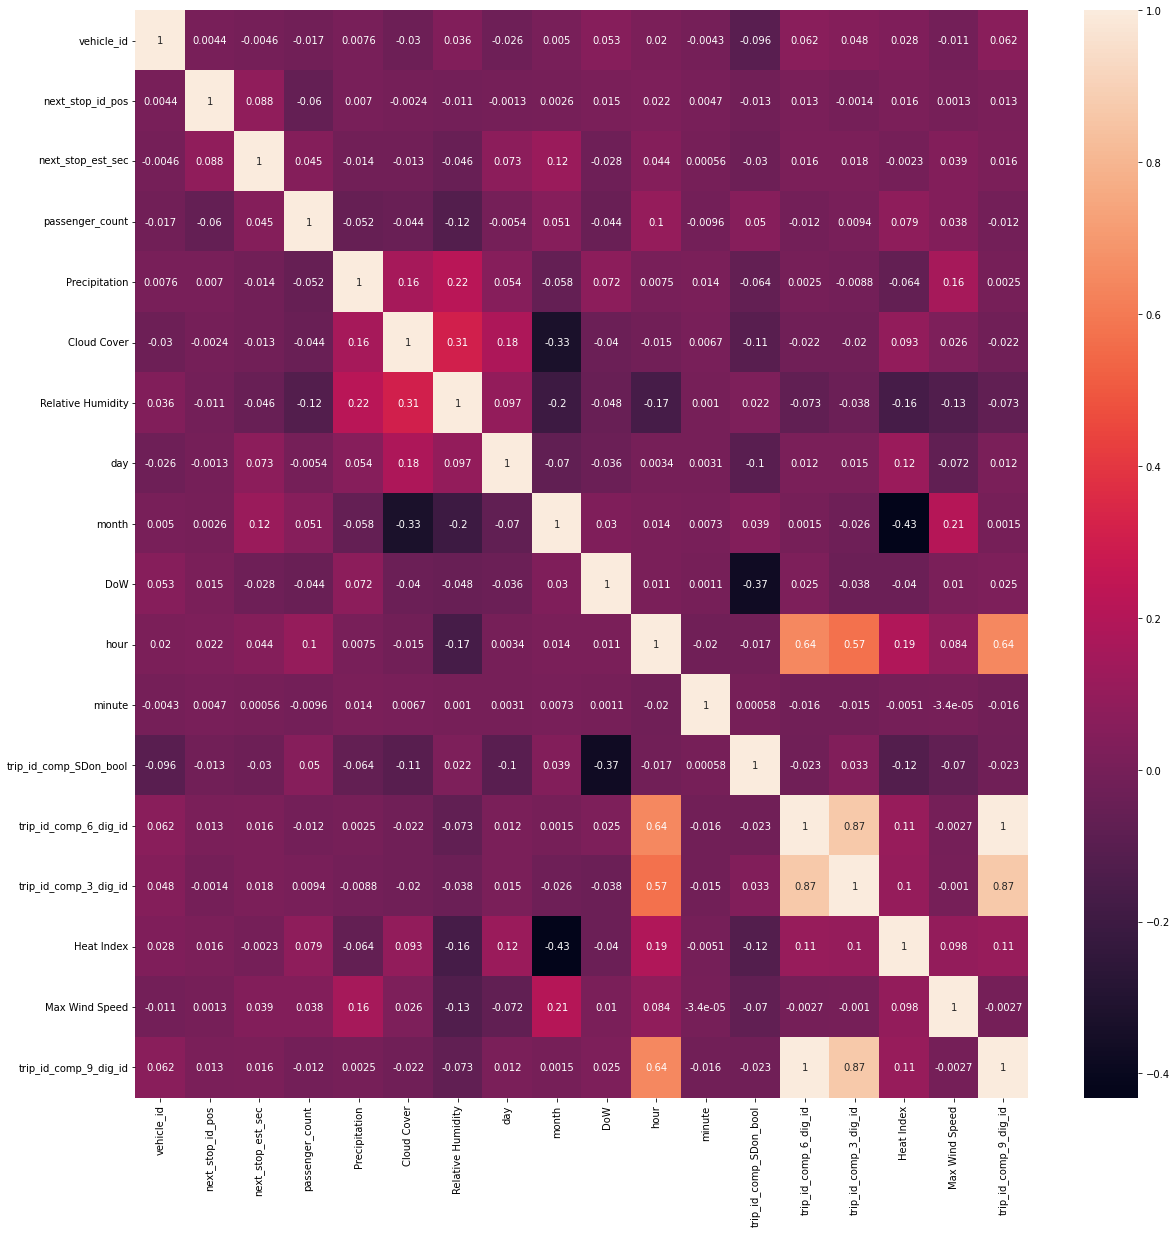

In [ ]:
corr = route_weather_df_4_ml_0.drop(columns='year').corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2g")
plt.show()

In [ ]:
train_x, train_y, test_x, test_y = custom_train_test_split(route_weather_df_4_ml_0, split_heuristic='arbitrary', test_size=0.1, split_date=(9, 27, 2021), split_time=(0, 0), n=1, random_state=0)

In [ ]:
model = train_eval_rf(train_x, train_y, test_x, test_y)

Train
MAE: 0.8
ME : 27.7
R^2: 0.98


Test
MAE: 2.2
ME : 28.0
R^2: 0.87




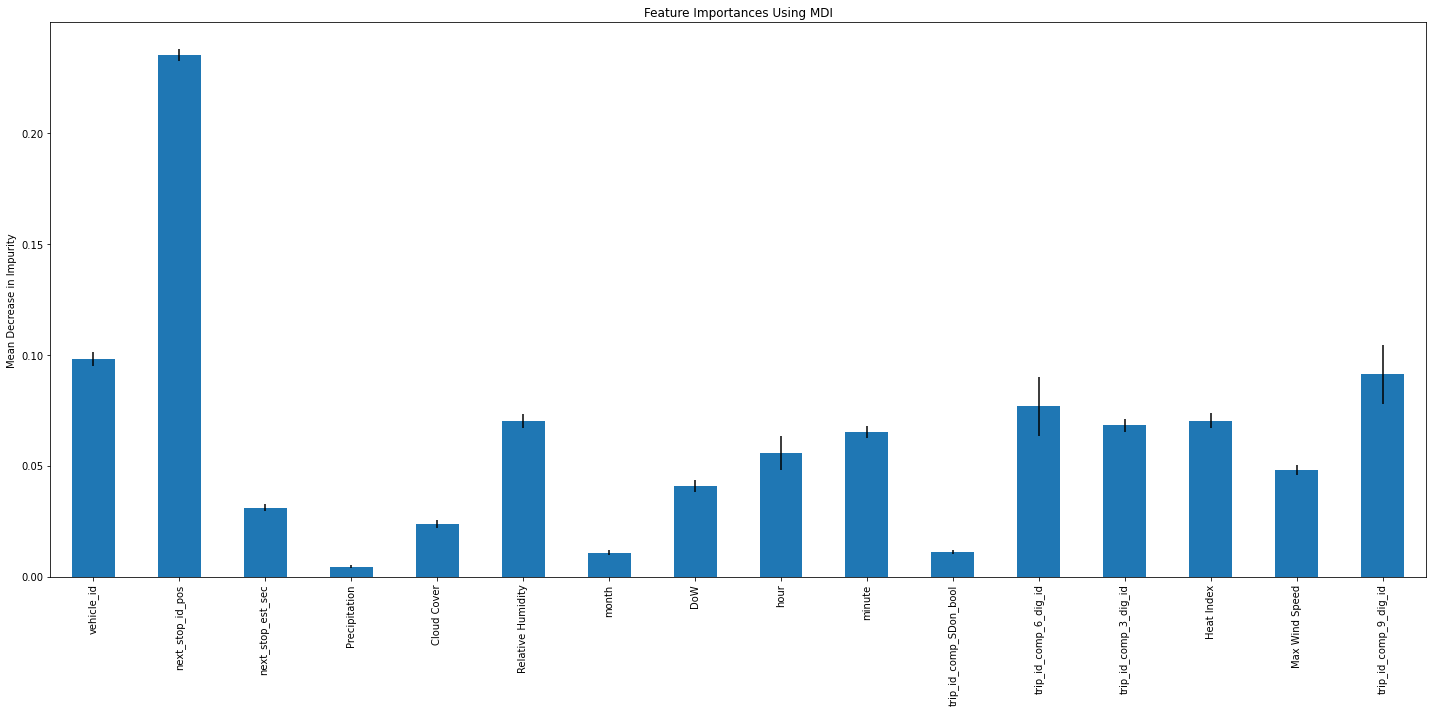

In [ ]:
plot_importance(model, train_x)

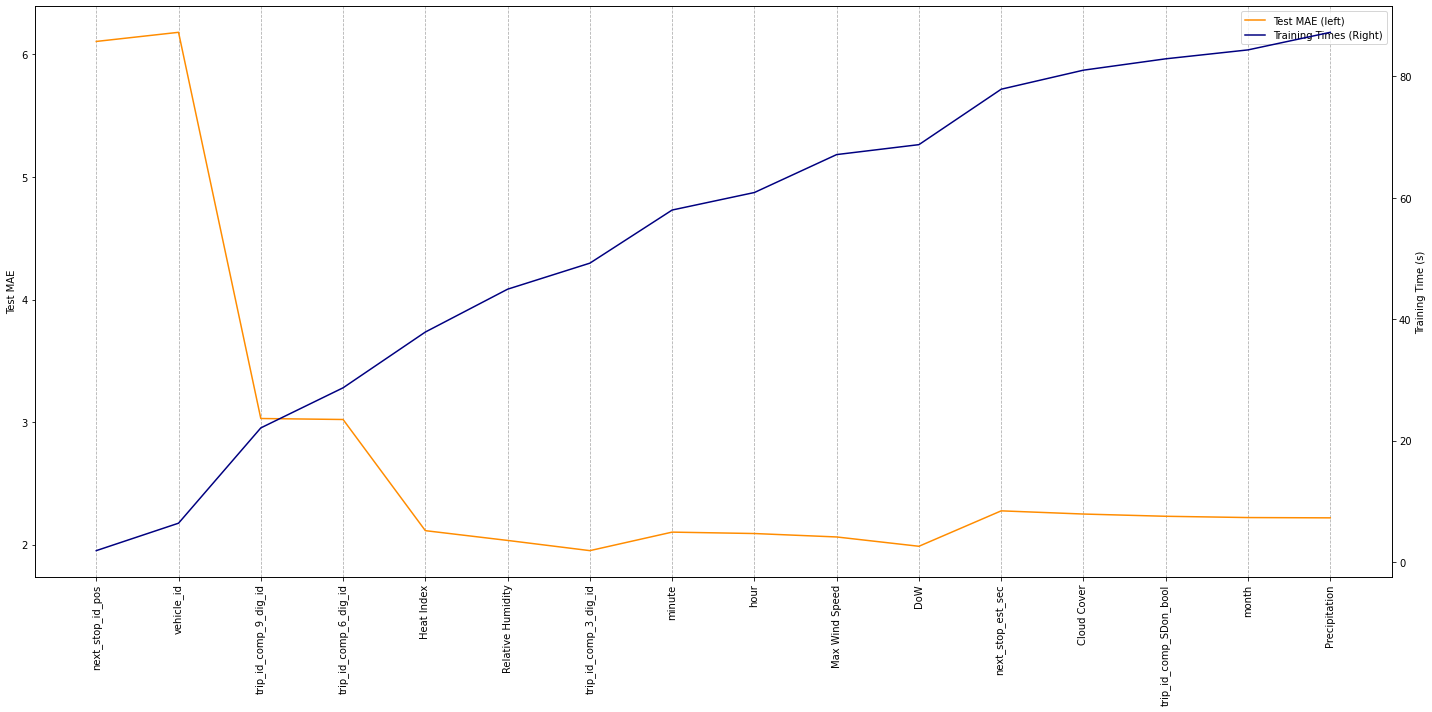

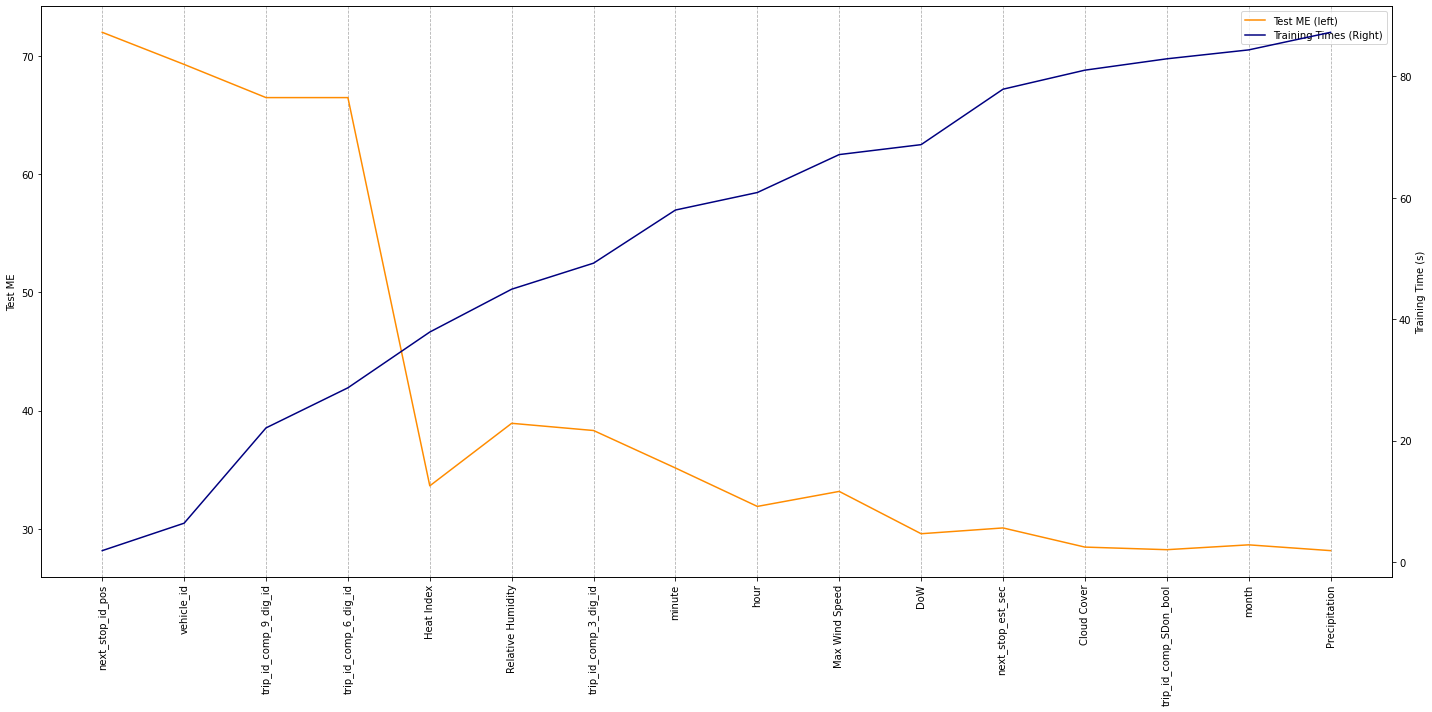

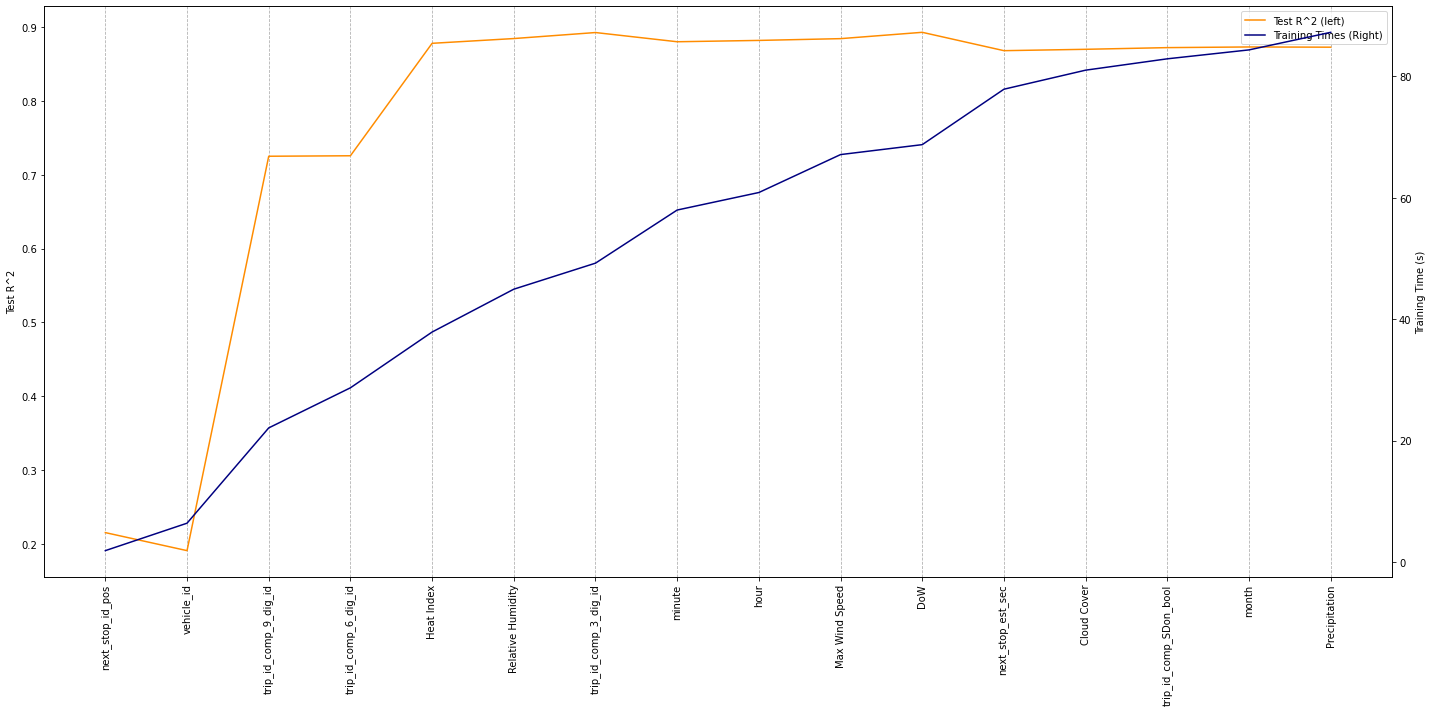

In [ ]:
plot_cumulative_importance(model, train_x, train_y, test_x, test_y)

## Direction 1

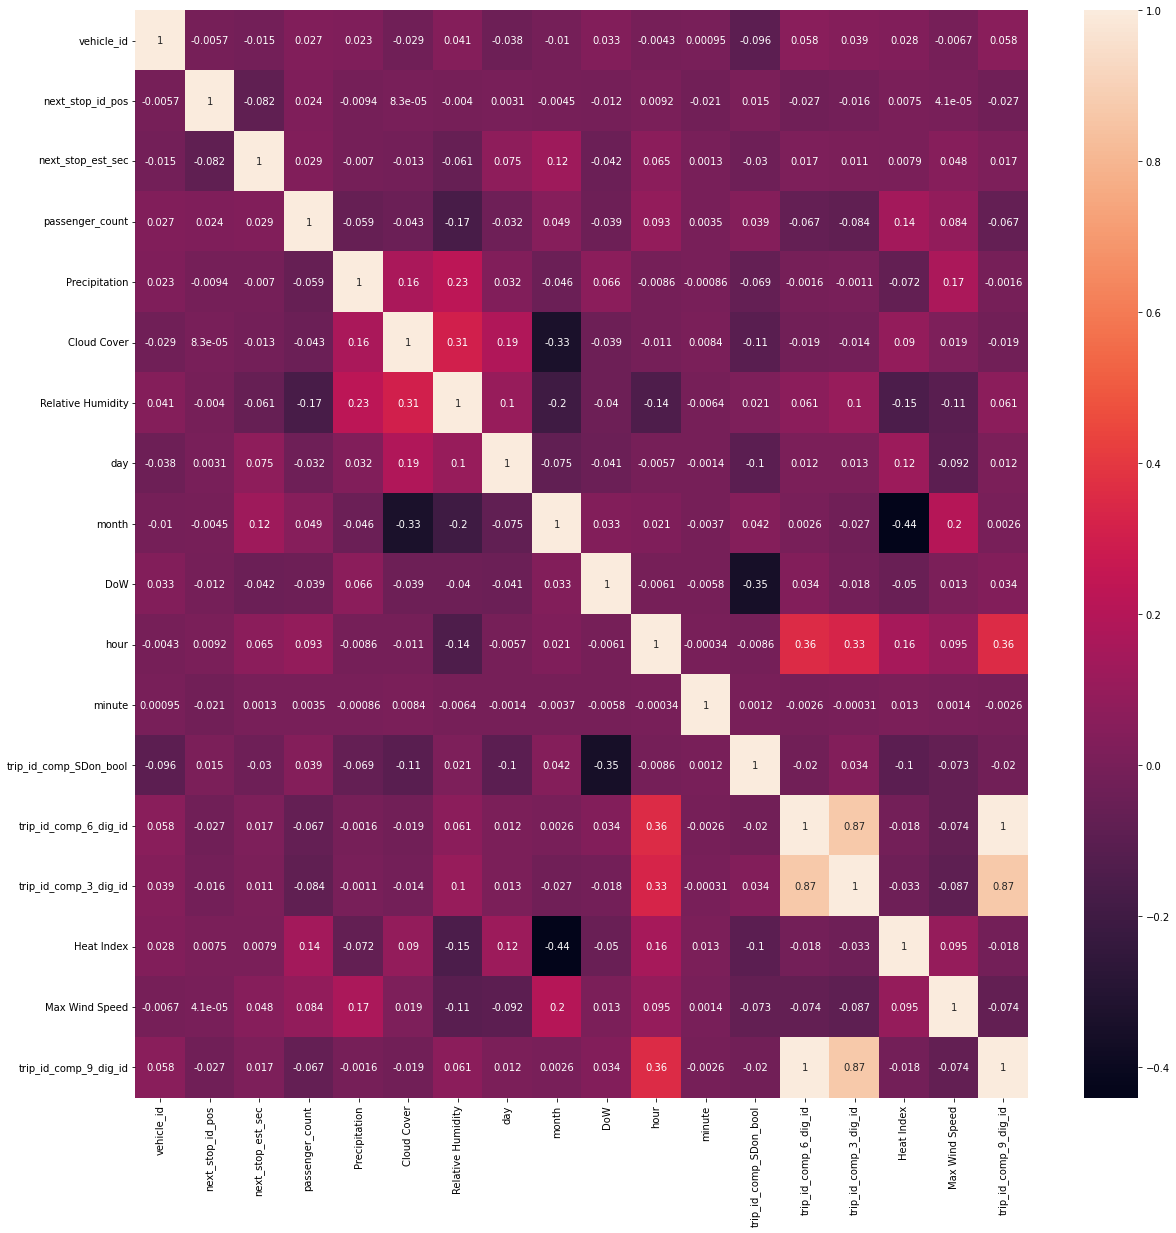

In [ ]:
corr = route_weather_df_4_ml_1.drop(columns='year').corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2g")
plt.show()

In [ ]:
train_x, train_y, test_x, test_y = custom_train_test_split(route_weather_df_4_ml_1, split_heuristic='arbitrary', test_size=0.1, split_date=(9, 27, 2021), split_time=(0, 0), n=1, random_state=0)

In [ ]:
model = train_eval_rf(train_x, train_y, test_x, test_y)

Train
MAE: 0.8
ME : 33.5
R^2: 0.98


Test
MAE: 2.1
ME : 38.2
R^2: 0.89




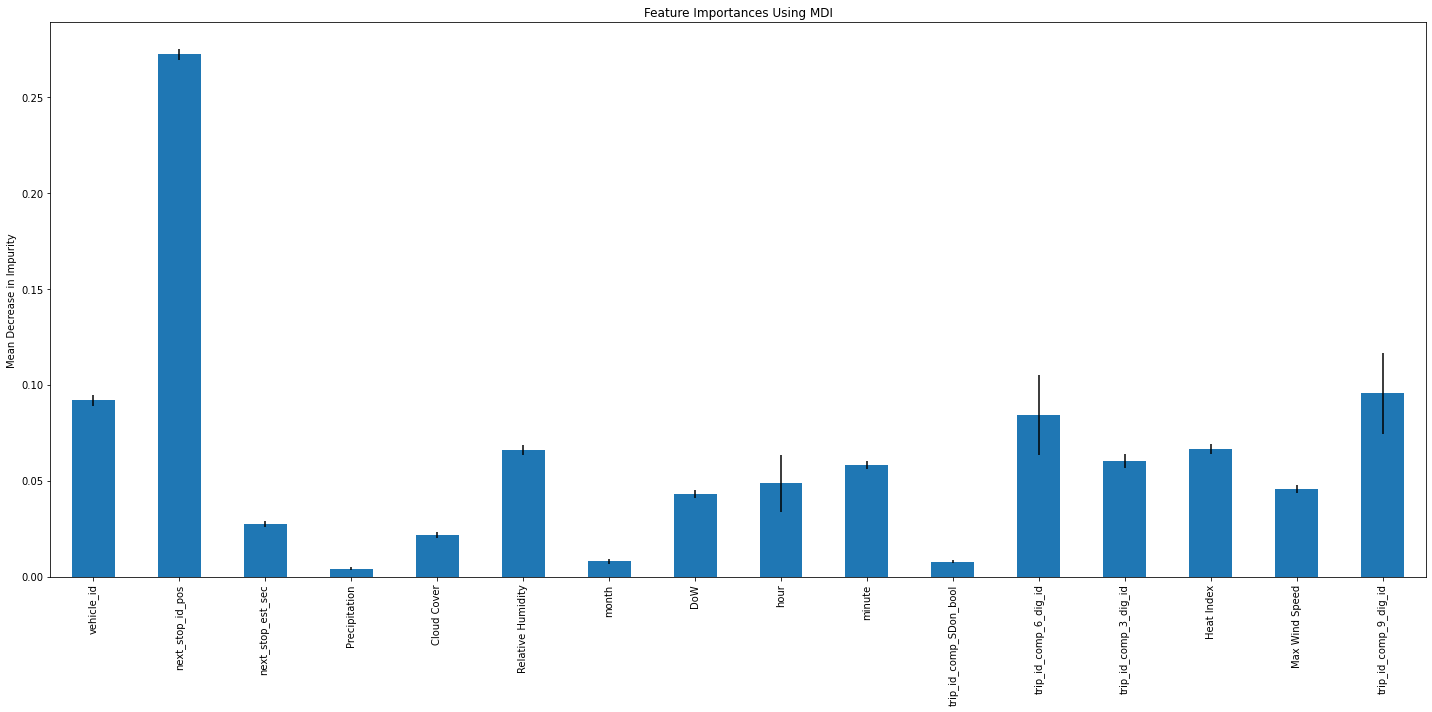

In [ ]:
plot_importance(model, train_x)

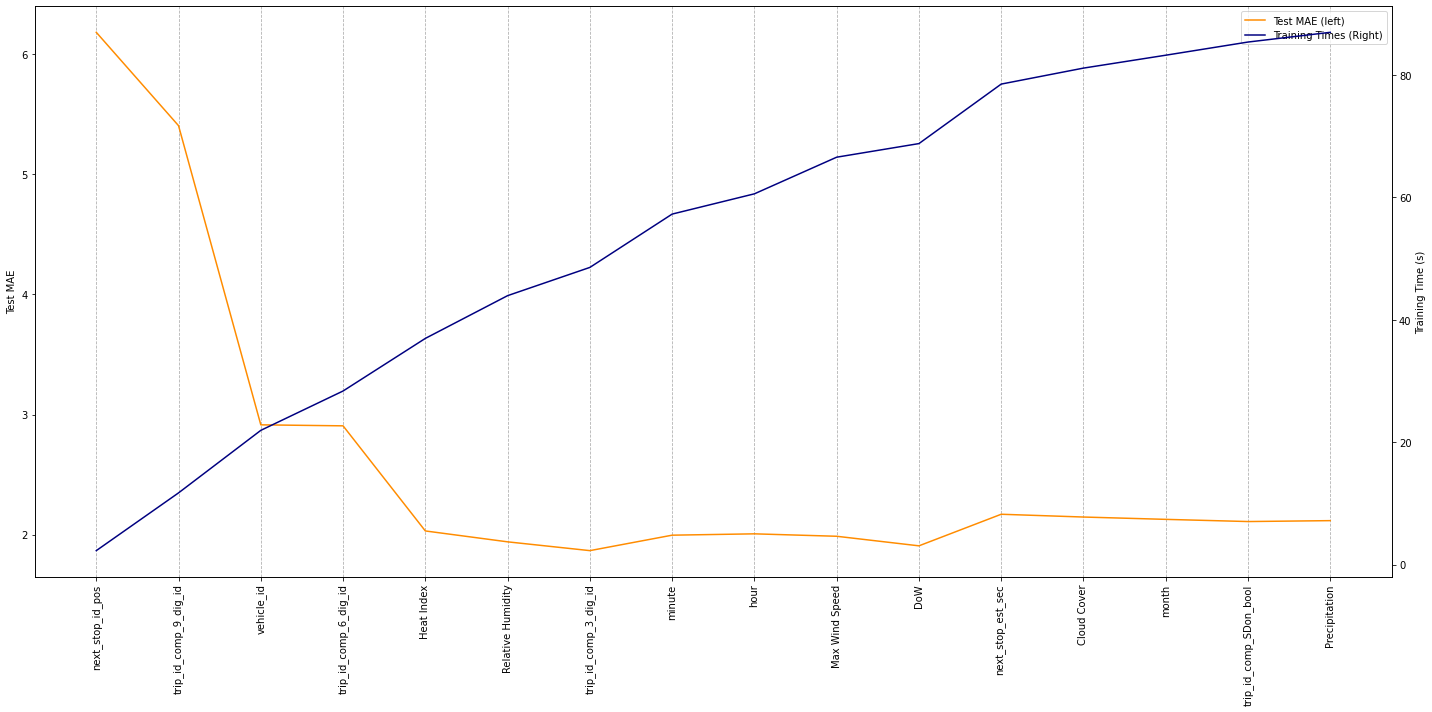

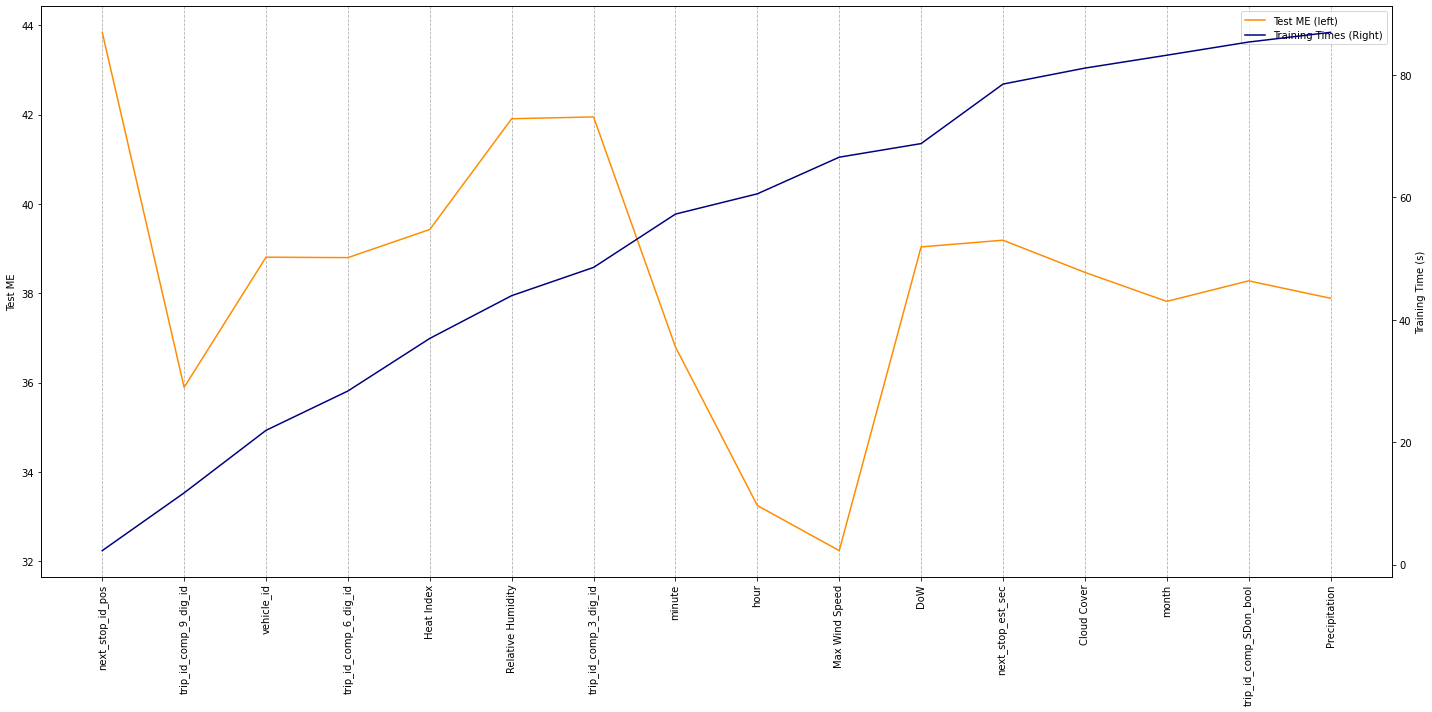

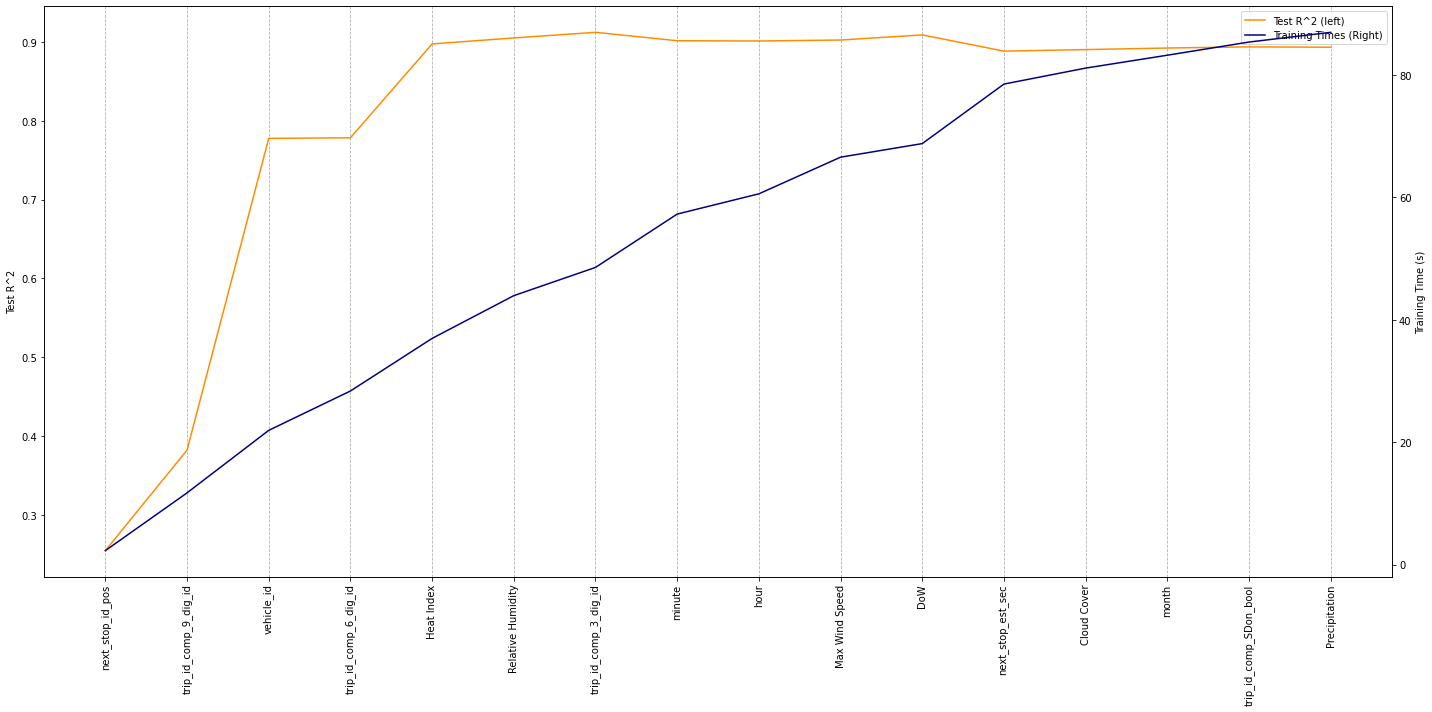

In [ ]:
plot_cumulative_importance(model, train_x, train_y, test_x, test_y)

# Feature Selection (Direction 1)

## Time

### DateTime Only

In [ ]:
# test DateTime features only (i.e. no trip_id components)
train_x_time_cols_only = train_x.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_3_dig_id', 'trip_id_comp_9_dig_id'])
test_x_time_cols_only = test_x.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_3_dig_id', 'trip_id_comp_9_dig_id'])

train_eval_rf(train_x_time_cols_only, train_y, test_x_time_cols_only, test_y)

Train
MAE: 0.9
ME : 35.9
R^2: 0.98


Test
MAE: 2.5
ME : 38.9
R^2: 0.86




RandomForestRegressor(random_state=0)

### 9-digit ID Only

In [ ]:
# test 9-digit trip_id only (i.e. no DateTime features)
train_x_9_dig_only = train_x.drop(columns=['month', 'DoW', 'hour', 'minute', 'trip_id_comp_6_dig_id', 'trip_id_comp_3_dig_id'])
test_x_9_dig_only = test_x.drop(columns=['month', 'DoW', 'hour', 'minute', 'trip_id_comp_6_dig_id', 'trip_id_comp_3_dig_id'])

train_eval_rf(train_x_9_dig_only, train_y, test_x_9_dig_only, test_y)

Train
MAE: 0.8
ME : 34.0
R^2: 0.98


Test
MAE: 2.3
ME : 41.9
R^2: 0.88




RandomForestRegressor(random_state=0)

### 6- and 3-digit ID

In [ ]:
# test 6- and 3-digit trip_id only (i.e. no DateTime features)
train_x_6_3_dig_only = train_x.drop(columns=['month', 'DoW', 'hour', 'minute', 'trip_id_comp_9_dig_id'])
test_x_6_3_dig_only = test_x.drop(columns=['month', 'DoW', 'hour', 'minute', 'trip_id_comp_9_dig_id'])

train_eval_rf(train_x_6_3_dig_only, train_y, test_x_6_3_dig_only, test_y)

Train
MAE: 0.8
ME : 36.2
R^2: 0.98


Test
MAE: 2.2
ME : 41.5
R^2: 0.89




RandomForestRegressor(random_state=0)

### Revisit DateTime Only...

In [ ]:
# problem: trip_id components not robust to schedule changes, etc. and give only minor uptick in performance
# solution: use datetime features only (always observable)
# check model importances...

model = train_eval_rf(train_x_time_cols_only, train_y, test_x_time_cols_only, test_y)

Train
MAE: 0.9
ME : 35.9
R^2: 0.98


Test
MAE: 2.5
ME : 38.9
R^2: 0.86




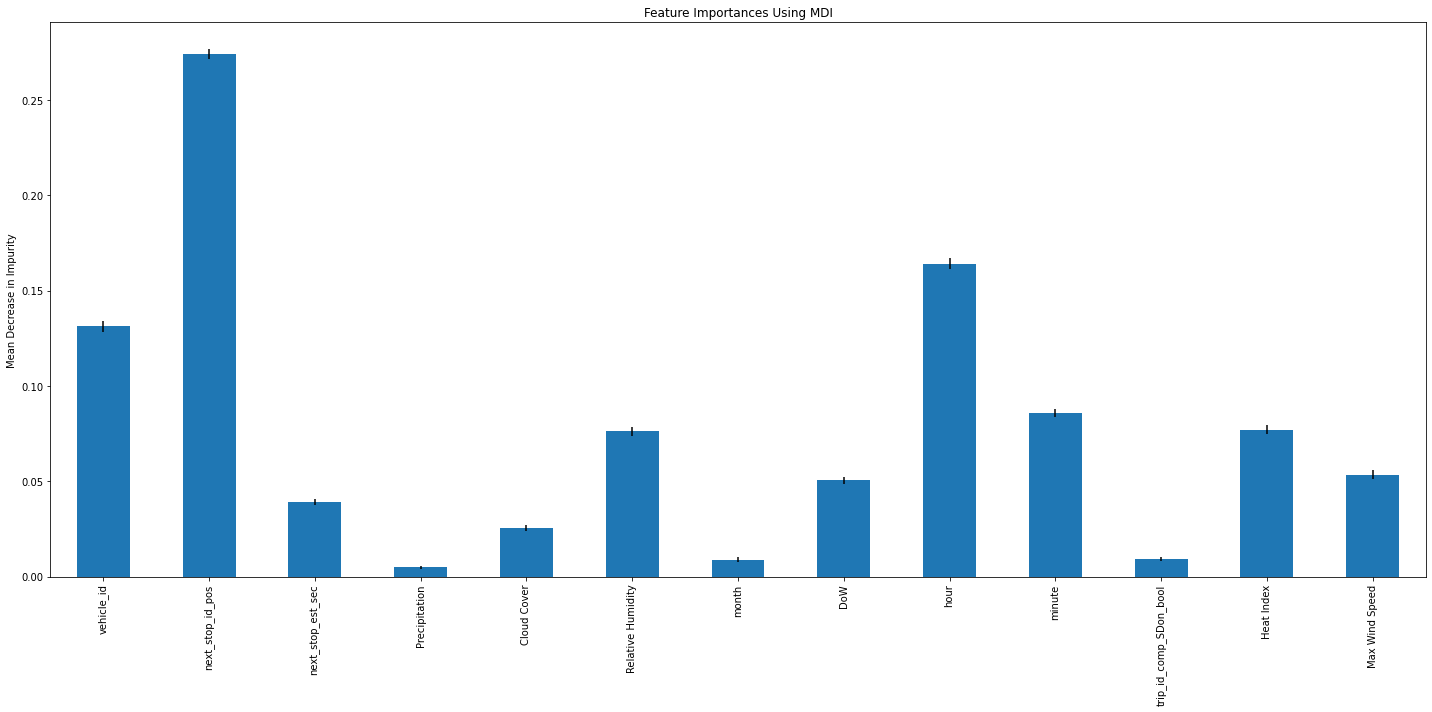

In [ ]:
plot_importance(model, train_x_time_cols_only)

#### Drop `vehicle_id`...

In [ ]:
# what if we exclude vehicle_id?
train_x_time_cols_only_no_vid = train_x_time_cols_only.drop(columns='vehicle_id')
test_x_time_cols_only_no_vid = test_x_time_cols_only.drop(columns='vehicle_id')

model = train_eval_rf(train_x_time_cols_only_no_vid, train_y, test_x_time_cols_only_no_vid, test_y)

Train
MAE: 1.3
ME : 35.9
R^2: 0.96


Test
MAE: 3.5
ME : 37.0
R^2: 0.71




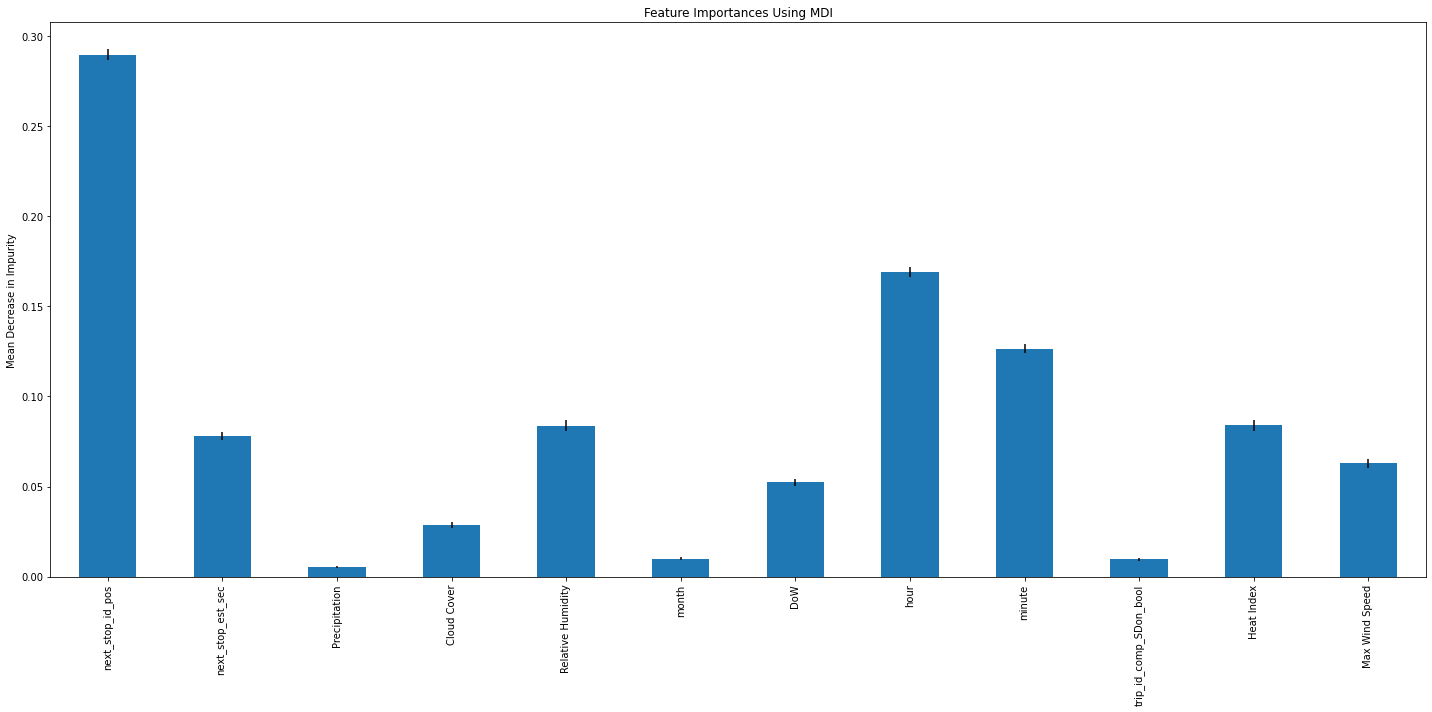

In [ ]:
plot_importance(model, train_x_time_cols_only_no_vid)

#### Split on date... 

In [ ]:
# dropping vehicle_id leads to steep falloff in performance... 
# are we leaking target info through vehicle_id (and 3- / 6-digit components of trip_id for that matter)?  
# does it provide any predictive value when data is split on date / time?
train_x_date, train_y_date, test_x_date, test_y_date = custom_train_test_split(route_weather_df_4_ml_1, split_heuristic='date', test_size=0.1, split_date=(9, 27, 2021), split_time=(0, 0), n=1, random_state=0)

In [ ]:
# drop 3- / 6- / 9-digit components of trip_id
train_x_date_time_cols_only = train_x_date.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_3_dig_id', 'trip_id_comp_9_dig_id'])
test_x_date_time_cols_only = test_x_date.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_3_dig_id', 'trip_id_comp_9_dig_id'])

model = train_eval_rf(train_x_date_time_cols_only, train_y_date, test_x_date_time_cols_only, test_y_date)

Train
MAE: 0.9
ME : 28.6
R^2: 0.98


Test
MAE: 5.2
ME : 32.9
R^2: 0.38




In [ ]:
# drop 6- / 9-digit components of trip_id
train_x_date_time_cols_only = train_x_date.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_9_dig_id'])
test_x_date_time_cols_only = test_x_date.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_9_dig_id'])

model = train_eval_rf(train_x_date_time_cols_only, train_y_date, test_x_date_time_cols_only, test_y_date)

Train
MAE: 0.8
ME : 28.4
R^2: 0.99


Test
MAE: 4.9
ME : 30.7
R^2: 0.44




In [ ]:
# drop 9-digit components of trip_id, only
train_x_date_time_cols_only = train_x_date.drop(columns=['trip_id_comp_9_dig_id'])
test_x_date_time_cols_only = test_x_date.drop(columns=['trip_id_comp_9_dig_id'])

model = train_eval_rf(train_x_date_time_cols_only, train_y_date, test_x_date_time_cols_only, test_y_date)

Train
MAE: 0.7
ME : 28.6
R^2: 0.99


Test
MAE: 4.8
ME : 35.8
R^2: 0.45




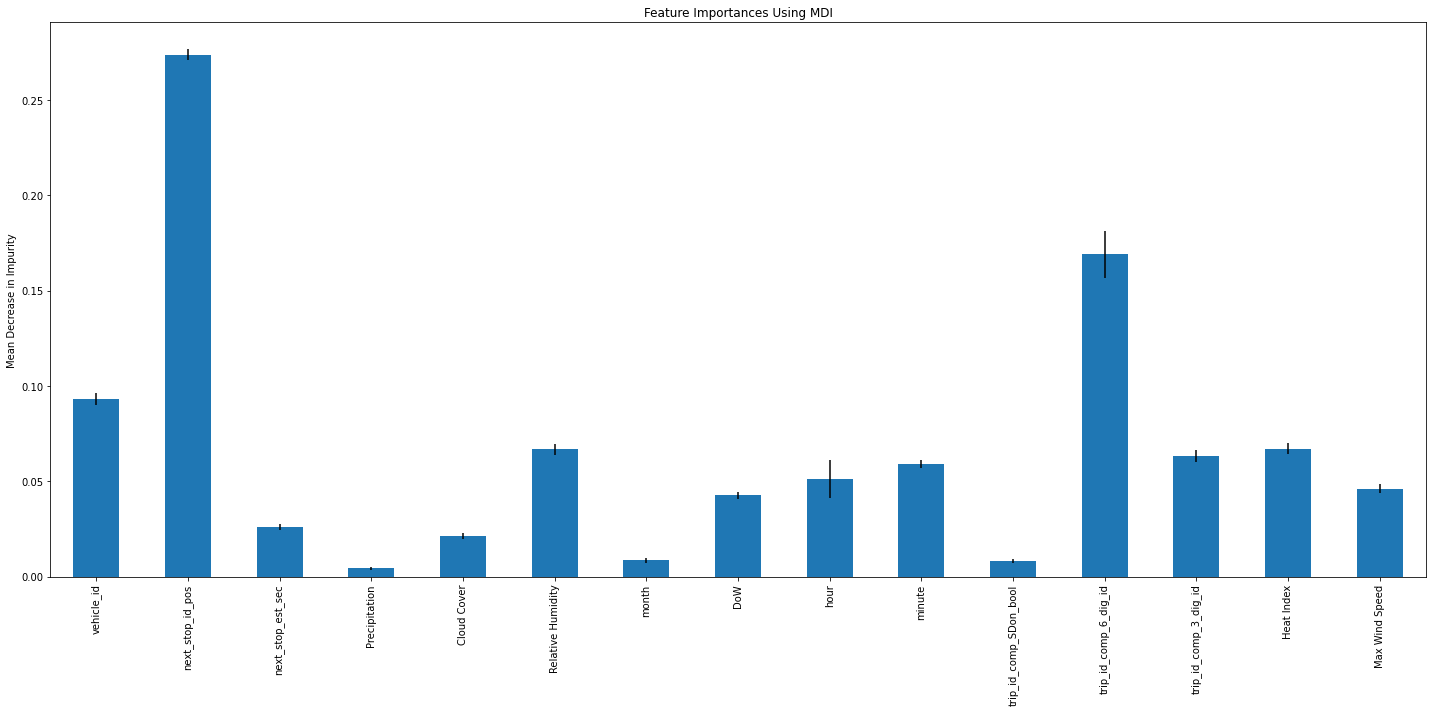

In [ ]:
plot_importance(model, train_x_date_time_cols_only)

### Conclusion

In [ ]:
train_x_date, train_y_date, test_x_date, test_y_date = custom_train_test_split(route_weather_df_4_ml_1, split_heuristic='date', test_size=0.1, split_date=(9, 27, 2021), split_time=(0, 0), n=1, random_state=0)

# only use DateTime features and 3-digit component of trip_id for max performance uptick with minimal risk of overfitting
train_x_date = train_x_date.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_9_dig_id'])
test_x_date = test_x_date.drop(columns=['trip_id_comp_6_dig_id', 'trip_id_comp_9_dig_id'])

## Weather

In [ ]:
def discretize_weather_feature(train_x, test_x, feature, n_bins, encode='ordinal', strategy='uniform'):
  train_temp = train_x.copy()
  test_temp = test_x.copy()
  est = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
  est.fit(np.array(train_temp[feature]).reshape(-1, 1))
  train_temp[feature] = est.transform(np.array(train_temp[feature]).reshape(-1, 1))
  test_temp[feature] = est.transform(np.array(test_temp[feature]).reshape(-1, 1))
  return train_temp, test_temp

In [ ]:
n_precip = 2
n_other = 5

# discretize Precipitation
train_x_date_weather_encoding, test_x_date_weather_encoding = discretize_weather_feature(train_x_date, test_x_date, 'Precipitation', n_bins=n_precip, encode='ordinal', strategy='uniform')

# discretize Cloud Cover
train_x_date_weather_encoding, test_x_date_weather_encoding = discretize_weather_feature(train_x_date_weather_encoding, test_x_date_weather_encoding, 'Cloud Cover', n_bins=n_other, encode='ordinal', strategy='uniform')

# discretize Relative Humidity
train_x_date_weather_encoding, test_x_date_weather_encoding = discretize_weather_feature(train_x_date_weather_encoding, test_x_date_weather_encoding, 'Relative Humidity', n_bins=n_other, encode='ordinal', strategy='uniform')

# discretize Head Index
train_x_date_weather_encoding, test_x_date_weather_encoding = discretize_weather_feature(train_x_date_weather_encoding, test_x_date_weather_encoding, 'Heat Index', n_bins=n_other, encode='ordinal', strategy='uniform')

# discretize Max Wind Speed
train_x_date_weather_encoding, test_x_date_weather_encoding = discretize_weather_feature(train_x_date_weather_encoding, test_x_date_weather_encoding, 'Max Wind Speed', n_bins=n_other, encode='ordinal', strategy='uniform')

In [ ]:
model = train_eval_rf(train_x_date_weather_encoding, train_y_date, test_x_date_weather_encoding, test_y_date)

Train
MAE: 0.8
ME : 29.4
R^2: 0.98


Test
MAE: 4.9
ME : 33.3
R^2: 0.44




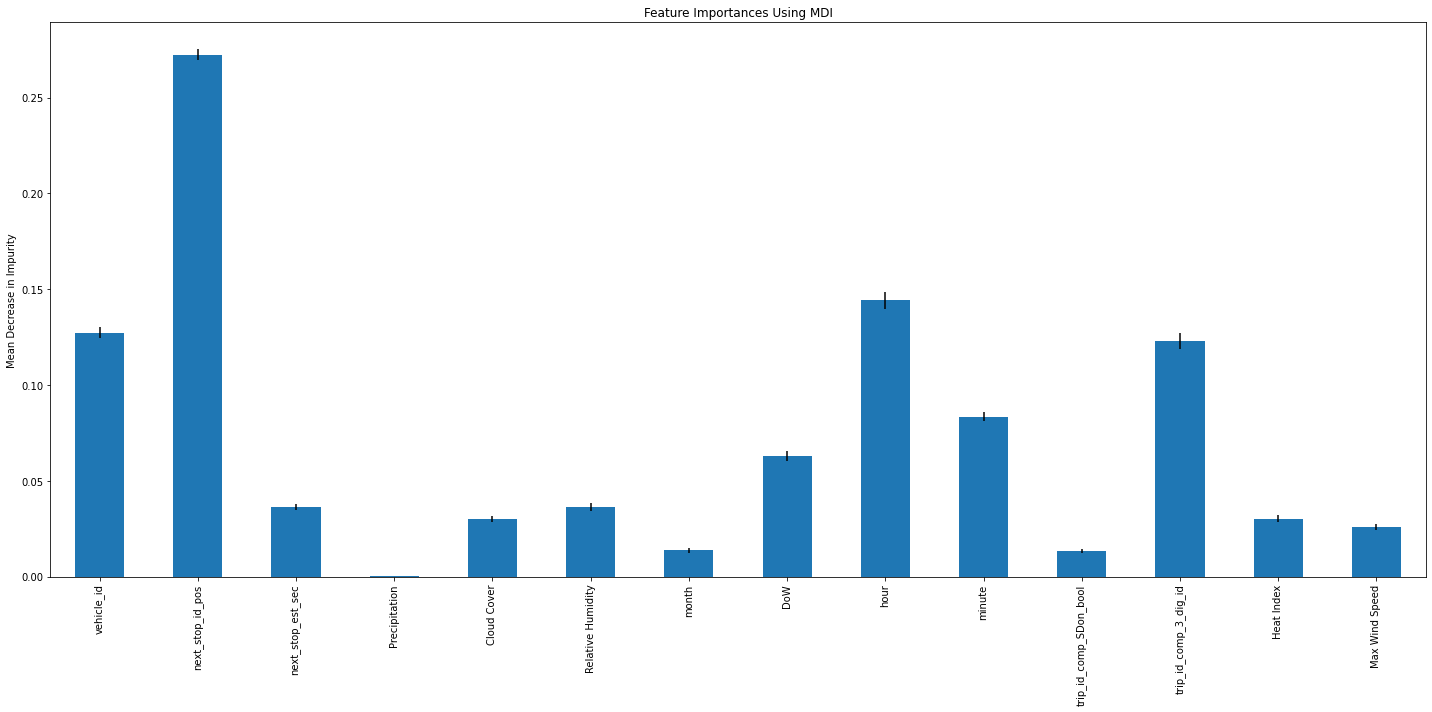

In [ ]:
plot_importance(model, train_x_date_weather_encoding)

### Conclusion

In [ ]:
# discretizing weather does not seem to help...

## Final Global Feature Set

In [ ]:
# run "final" global feature set on data split on date
model = train_eval_rf(train_x_date, train_y_date, test_x_date, test_y_date)

Train
MAE: 0.8
ME : 28.4
R^2: 0.99


Test
MAE: 4.9
ME : 30.7
R^2: 0.44




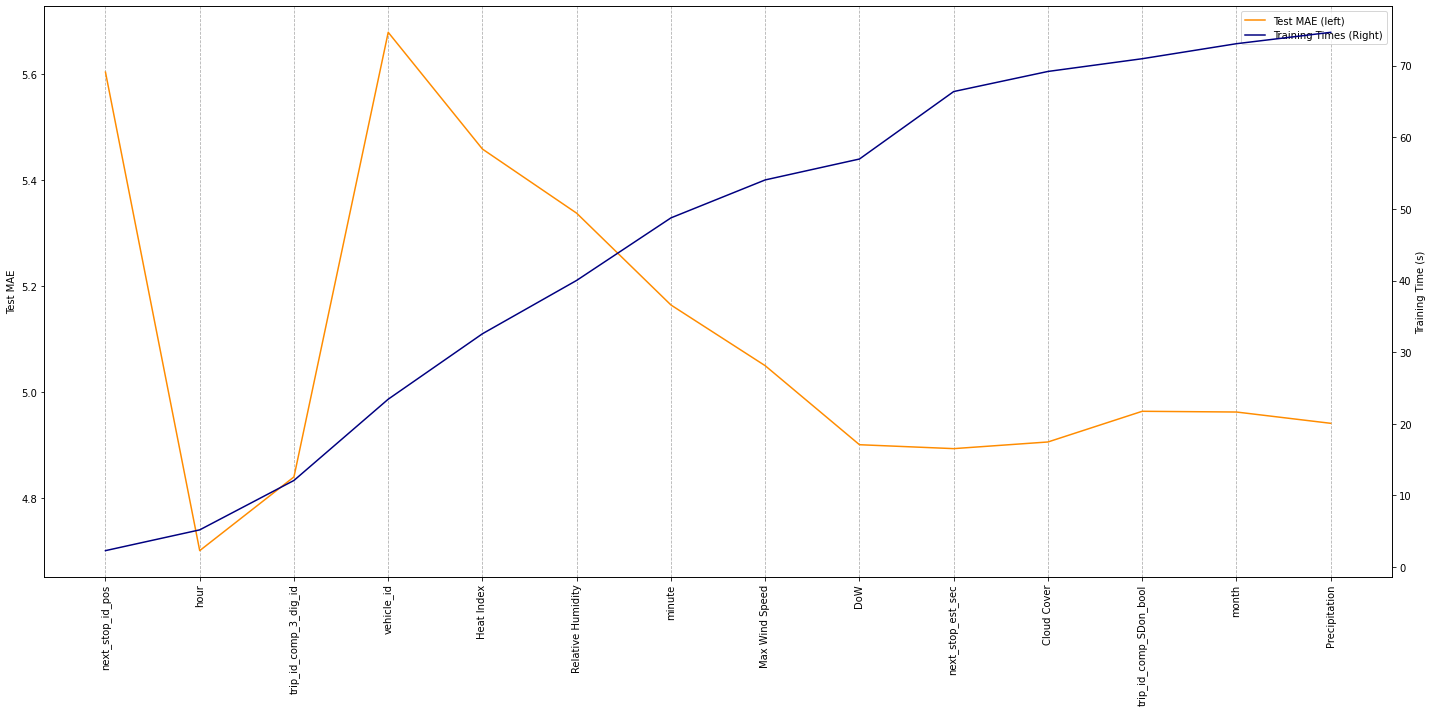

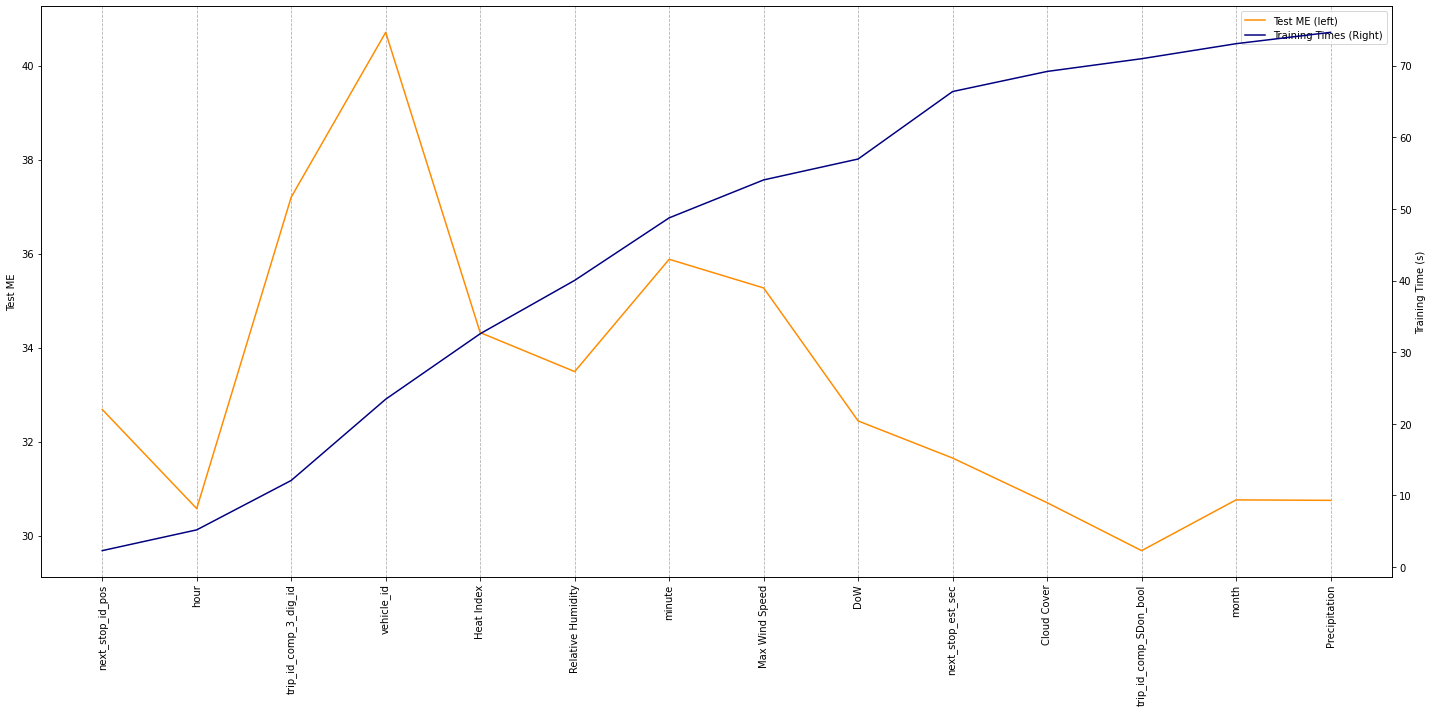

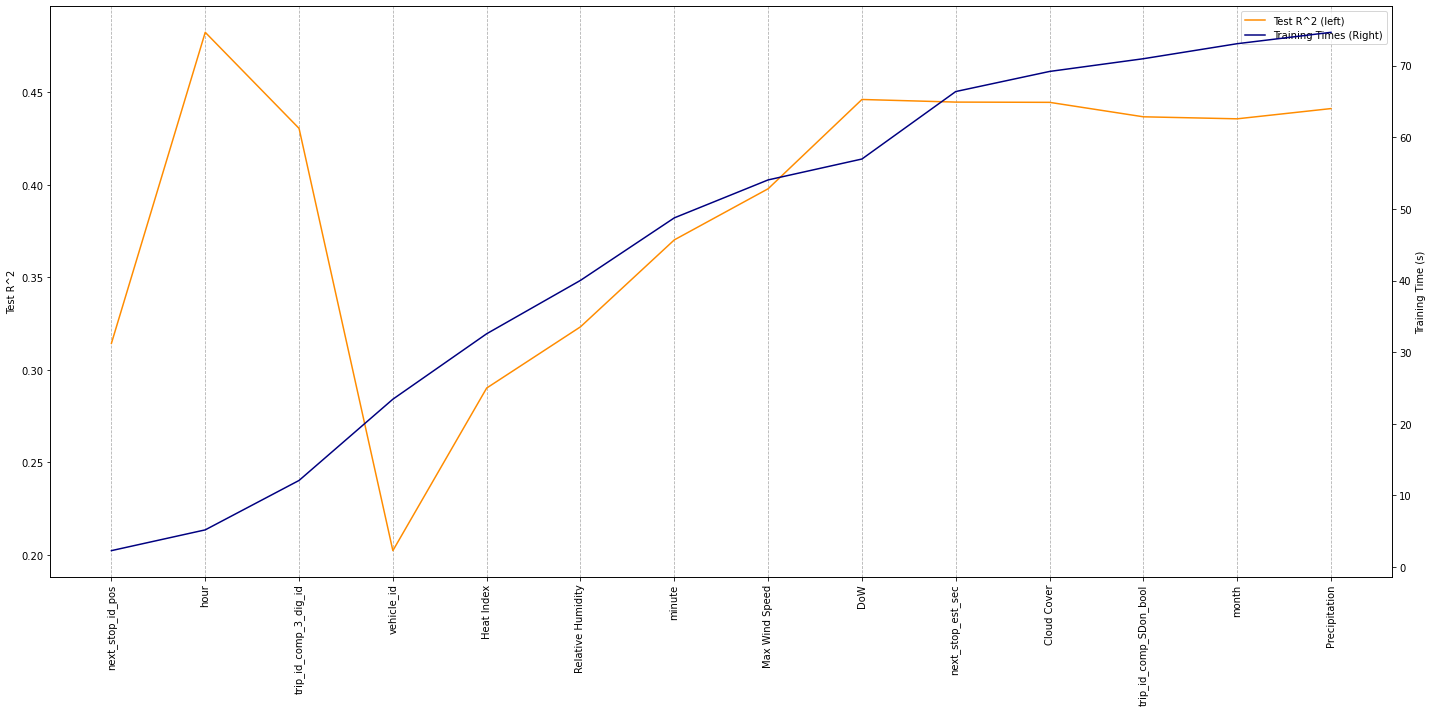

In [ ]:
plot_cumulative_importance(model, train_x_date, train_y_date, test_x_date, test_y_date)